# 10-1. 프로젝트: 한국어 데이터로 챗봇 만들기

영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜봅시다.

시작하기 전에 우선 주요 라이브러리 버전을 확인해 봅시다.

In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


### Step 1. 데이터 수집하기
---
한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.

- songys/Chatbot_data  
https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv  

Cloud shell에서 아래 명령어를 입력해 주세요.

```
$ mkdir -p ~/aiffel/transformer_chatbot/data/
$ ln -s ~/data/* ~/aiffel/transformer_chatbot/data/
```

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import re

In [3]:
# 파일 경로
file_path = '~/aiffel/transformer_chatbot/data/ChatbotData .csv'

### 파일 이름에 띄어쓰기가 있었음!! 챗봇 데이터 github 에도 내용 있음...
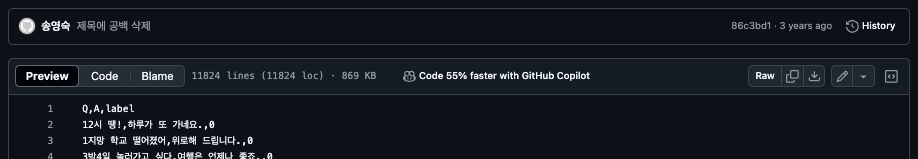

### 이 프로젝트에서는 질문과 답변 쌍만 사용하여 모델을 학습시키고, label 정보는 사용하지 않음
- label이 모델 학습에 필요하지 않음
- 이 프로젝트의 목표는 주어진 질문(Q)에 대해 답변(A)을 생성 하는것
- 모델 복잡도 감소
- 감정 기반 챗봇이나 대화 유형에 따른 답변 생성을 목표로 하는 경우 필요함

In [4]:
# 1. 데이터 로드
def load_korean_data(file_path):
    # 데이터 로드
    data = pd.read_csv(file_path)
    print("전체 데이터 수:", len(data))
    print(data.head())
    data = data[['Q', 'A']]  # 질문과 답변만 사용
    data = data.dropna()  # 결측값 제거
    return data['Q'].tolist(), data['A'].tolist()

In [5]:
questions, answers = load_korean_data(file_path)

전체 데이터 수: 11823
                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0


In [6]:
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [7]:
# 결과 확인
print("샘플 질문:", questions[:5])
print("샘플 답변:", answers[:5])

샘플 질문: ['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
샘플 답변: ['하루가 또 가네요.', '위로해 드립니다.', '여행은 언제나 좋죠.', '여행은 언제나 좋죠.', '눈살이 찌푸려지죠.']


### Step 2. 데이터 전처리하기
---
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

In [8]:
MAX_SAMPLES = 50000  # 사용할 최대 샘플 수
MAX_LENGTH = 40  # 최대 시퀀스 길이

In [9]:
# 2. 전처리 함수
def preprocess_sentence(sentence):
    # 특수문자 제거
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9?.!,]+", " ", sentence)
    # 공백 제거
    sentence = re.sub(r"\s+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [10]:
# 2. 데이터 전처리
def preprocess_data(questions, answers):
    # 전처리 적용
    questions = [preprocess_sentence(q) for q in questions]
    answers = [preprocess_sentence(a) for a in answers]
    return questions, answers

In [12]:
# 전처리 함수 Test
sentence = "안녕하세요! 123  #^^*& Test"
preprocessed = preprocess_sentence(sentence)
print(preprocessed)

안녕하세요! 123 Test


In [11]:
questions, answers = preprocess_data(questions, answers)

### Step 3. SubwordTextEncoder 사용하기
---
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

In [13]:
# 3. SubwordTextEncoder 생성
def create_tokenizer(questions, answers, vocab_size=2**13):
    corpus = questions + answers
    tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
        corpus, target_vocab_size=vocab_size
    )
    return tokenizer

In [14]:
tokenizer = create_tokenizer(questions, answers)

In [15]:
# 4. 정수 인코딩 및 시작/종료 토큰 추가
def encode_and_pad(questions, answers, tokenizer, max_length):
    # 시작 및 종료 토큰 정의
    START_TOKEN = [tokenizer.vocab_size]  # 시작 토큰은 어휘 크기 뒤에 추가
    END_TOKEN = [tokenizer.vocab_size + 1]  # 종료 토큰은 어휘 크기 + 1

    # 길이 제한을 적용하여 시작 및 종료 토큰 추가
    filtered_questions = []
    filtered_answers = []

    for q, a in zip(questions, answers):
        # 질문과 답변 각각에 시작 및 종료 토큰 추가
        encoded_q = START_TOKEN + tokenizer.encode(q) + END_TOKEN
        encoded_a = START_TOKEN + tokenizer.encode(a) + END_TOKEN

        # 최대 길이를 초과하지 않는 데이터만 추가
        if len(encoded_q) <= max_length and len(encoded_a) <= max_length:
            filtered_questions.append(encoded_q)
            filtered_answers.append(encoded_a)

    # 패딩 처리
    questions = pad_sequences(filtered_questions, maxlen=max_length, padding='post')
    answers = pad_sequences(filtered_answers, maxlen=max_length, padding='post')

    return questions, answers, START_TOKEN, END_TOKEN

In [16]:
# 4. 정수 인코딩 및 패딩 처리
questions, answers, START_TOKEN, END_TOKEN = encode_and_pad(
    questions, answers, tokenizer, MAX_LENGTH
)

In [17]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8168]
END_TOKEN의 번호 : [8169]


In [18]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2

In [19]:
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8170
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


### Teacher Forcing 사용

In [20]:
# 5. TensorFlow Dataset 생성
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

print(f"데이터셋 준비 완료: {len(questions)}개의 샘플")
print("예제 데이터셋:", next(iter(dataset)))

데이터셋 준비 완료: 11823개의 샘플
예제 데이터셋: ({'inputs': <tf.Tensor: shape=(64, 40), dtype=int32, numpy=
array([[8168,  342,  221, ...,    0,    0,    0],
       [8168,   67,  209, ...,    0,    0,    0],
       [8168, 1243,  833, ...,    0,    0,    0],
       ...,
       [8168, 7592,   25, ...,    0,    0,    0],
       [8168, 4229,   11, ...,    0,    0,    0],
       [8168, 4879, 1636, ...,    0,    0,    0]], dtype=int32)>, 'dec_inputs': <tf.Tensor: shape=(64, 39), dtype=int32, numpy=
array([[8168, 2248,  190, ...,    0,    0,    0],
       [8168,  909,  443, ...,    0,    0,    0],
       [8168,  538, 3049, ...,    0,    0,    0],
       ...,
       [8168, 1008, 1102, ...,    0,    0,    0],
       [8168, 4120, 1288, ...,    0,    0,    0],
       [8168, 1208, 8169, ...,    0,    0,    0]], dtype=int32)>}, {'outputs': <tf.Tensor: shape=(64, 39), dtype=int32, numpy=
array([[2248,  190,  414, ...,    0,    0,    0],
       [ 909,  443, 3783, ...,    0,    0,    0],
       [ 538, 3049,  538, ...

### Step 4. 모델 구성하기
---
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

In [21]:
import matplotlib.pyplot as plt

In [22]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

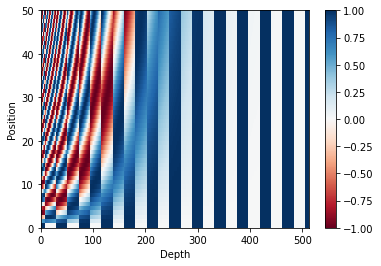

In [23]:
# Test
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [24]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

### 멀티-헤드 어텐션

In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth)) # [batch_size, seq_len, num_heads, depth] 
    return tf.transpose(inputs, perm=[0, 2, 1, 3]) # [batch_size, num_heads, seq_len, depth] 

  def call(self, inputs):
    # inputs는 딕셔너리 형태로 전달
    # query: Query 텐서의 형태는 [batch_size, seq_len, d_model]
    # key: Key 텐서의 형태는 [batch_size, seq_len, d_model]
    # value: Value 텐서의 형태는 [batch_size, seq_len, d_model]
    # mask: 마스크 텐서. 특정 토큰이나 위치를 가리기 위해 사용.
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)  # shape: (batch_size, seq_len, d_model)
    key = self.key_dense(key)        # shape: (batch_size, seq_len, d_model)
    value = self.value_dense(value)  # shape: (batch_size, seq_len, d_model)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)  # shape: (batch_size, num_heads, seq_len, depth)
    key = self.split_heads(key, batch_size)      # shape: (batch_size, num_heads, seq_len, depth)
    value = self.split_heads(value, batch_size)  # shape: (batch_size, num_heads, seq_len, depth)

    # 스케일드 닷 프로덕트 어텐션 함수
    #출력 : (batch_size, num_heads, seq_len, depth)
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    #출력 : (batch_size, seq_len, num_heads, depth)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    # 출력 : [batch_size, seq_len, d_model]
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    # 출력 : d_model
    outputs = self.dense(concat_attention)

    return outputs

### 패딩 마스킹(Padding Masking)

In [26]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

### 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)

In [27]:
def create_look_ahead_mask(x):
    # 입력 시퀀스의 길이를 계산
    seq_len = tf.shape(x)[1]

    # 정방행렬(seq_len x seq_len)의 하삼각 행렬을 생성
    # 하삼각 행렬이란, 대각선과 그 아래는 1, 위는 0인 행렬
    # 하삼각 행렬을 반전하여 룩 어헤드 마스크를 생성
    # 대각선 위는 1, 나머지는 0
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    
    padding_mask = create_padding_mask(x) # 패딩 마스크를 생성
    return tf.maximum(look_ahead_mask, padding_mask) # 두 마스크 중 하나라도 1인 위치는 최종 마스크에서도 1로 설정

In [28]:
# Test
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### Encoder

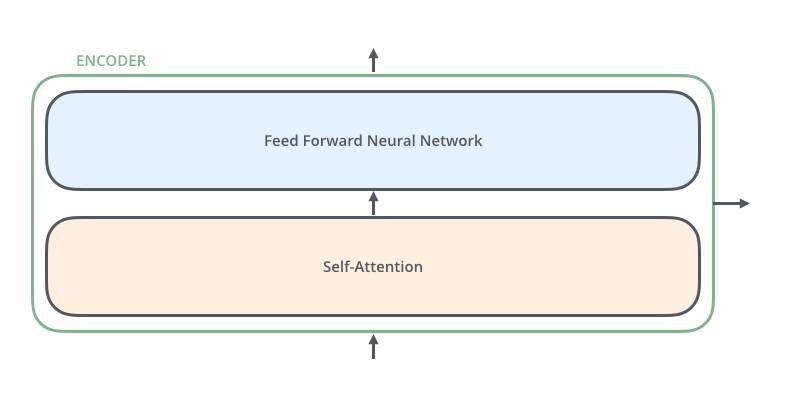
[출처 : http://jalammar.github.io/illustrated-transformer/]

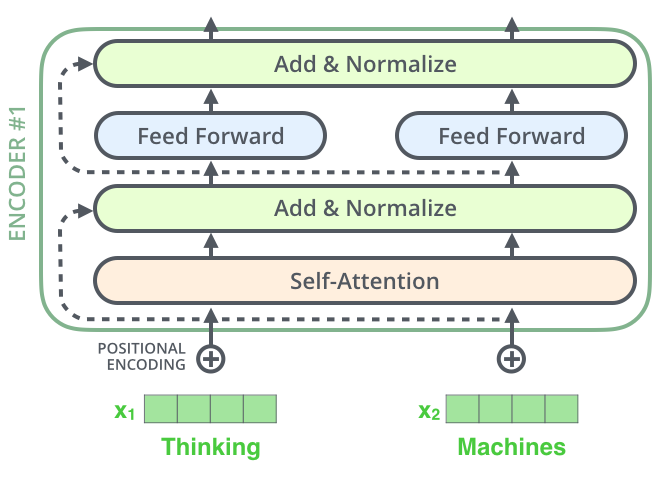  
[출처 : http://jalammar.github.io/illustrated-transformer/]

In [29]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 인코더 층을 쌓아 인코더 만들기

In [30]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 디코더

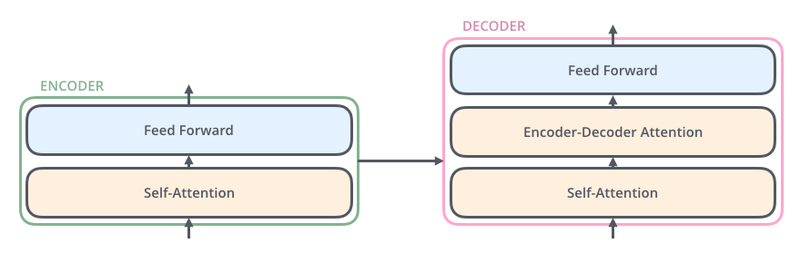  
[출처 : http://jalammar.github.io/illustrated-transformer/]

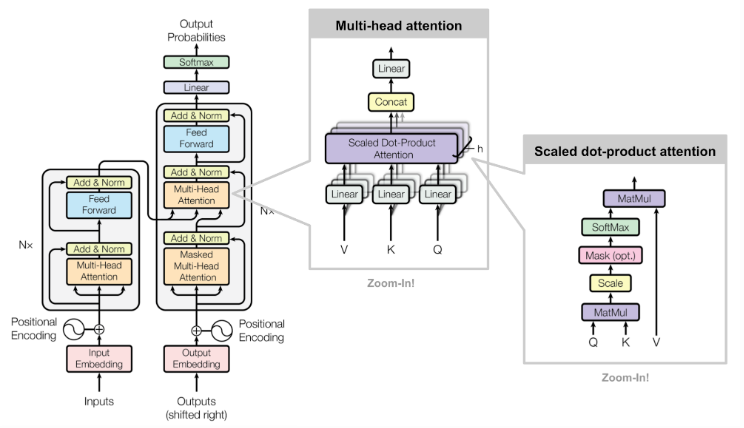
[출처 : https://medium.com/@shreyasikalra25/predict-movie-reviews-with-bert-88d8b79f5718]

In [31]:
# 디코더 하나의 레이어를 함수로 구현
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    # 디코더 입력: 디코더에 입력되는 임베딩 텐서
    # 입력 차원: (batch_size, seq_len, d_model)
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 인코더 출력: 인코더에서 나온 출력 텐서
    # 입력 차원: (batch_size, enc_seq_len, d_model)
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

    # 룩 어헤드 마스크: 미래 단어를 가리기 위한 마스크
    # 입력 차원: (batch_size, 1, seq_len, seq_len)
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

    # 패딩 마스크: 패딩된 위치를 무시하기 위한 마스크
    # 입력 차원: (batch_size, 1, 1, enc_seq_len)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어: 멀티 헤드 셀프 어텐션 수행
    # 디코더의 입력만 사용하여 셀프 어텐션을 계산
    # 출력 차원: (batch_size, seq_len, d_model)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,  # Query는 디코더의 입력
            'key': inputs,    # Key도 디코더의 입력
            'value': inputs,  # Value도 디코더의 입력
            'mask': look_ahead_mask  # 룩 어헤드 마스크 사용
        })

    # 첫 번째 서브 레이어 결과: Residual Connection + Layer Normalization
    # 출력 차원: (batch_size, seq_len, d_model)
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어: 인코더-디코더 멀티 헤드 어텐션 수행
    # 디코더 출력과 인코더 출력을 연결
    # 출력 차원: (batch_size, seq_len, d_model)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,       # Query는 첫 번째 서브 레이어의 결과
            'key': enc_outputs,        # Key는 인코더의 출력
            'value': enc_outputs,      # Value도 인코더의 출력
            'mask': padding_mask       # 패딩 마스크 사용
        })

    # 두 번째 서브 레이어 결과: Dropout + Residual Connection + Layer Normalization
    # 출력 차원: (batch_size, seq_len, d_model)
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어: 완전 연결층 (Feed-Forward Network)
    # 첫 번째 Dense 레이어 (ReLU 활성화)
    # 출력 차원: (batch_size, seq_len, units)
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)

    # 두 번째 Dense 레이어 (d_model 차원으로 출력 조정)
    # 출력 차원: (batch_size, seq_len, d_model)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 세 번째 서브 레이어 결과: Dropout + Residual Connection + Layer Normalization
    # 출력 차원: (batch_size, seq_len, d_model)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    # 최종 디코더 레이어 모델 반환
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],  # 디코더 입력
        outputs=outputs,  # 디코더 출력
        name=name)

# 디코더 레이어 함수 테스트
print("디코더 레이어 함수 테스트")

디코더 레이어 함수 테스트


### 디코더 층을 쌓아 디코더 만들기

In [32]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  # 디코더 입력: 정수 형태의 입력 시퀀스
  # 입력 차원: (batch_size, seq_len)
  inputs = tf.keras.Input(shape=(None,), name='inputs')

  # 인코더 출력: 인코더에서 나온 출력 텐서
  # 입력 차원: (batch_size, enc_seq_len, d_model)
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 룩 어헤드 마스크: 디코더에서 미래 단어를 가리기 위한 마스크
  # 입력 차원: (batch_size, 1, seq_len, seq_len)
  look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크: 패딩된 위치를 무시하기 위한 마스크
  # 입력 차원: (batch_size, 1, 1, enc_seq_len)
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어: 정수 입력 시퀀스를 d_model 크기의 벡터로 변환
  # 출력 차원: (batch_size, seq_len, d_model)
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)

  # 임베딩 벡터를 sqrt(d_model)로 스케일링
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩: 위치 정보를 추가
  # 출력 차원: (batch_size, seq_len, d_model)
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout: 과적합 방지를 위해 일부 노드를 비활성화
  # 출력 차원: (batch_size, seq_len, d_model)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 디코더 레이어를 쌓음
  for i in range(num_layers):
    # 각 디코더 레이어를 순차적으로 연결
    # 출력 차원: (batch_size, seq_len, d_model)
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  # 디코더 모델 반환
  # 입력: [디코더 입력, 인코더 출력, 룩 어헤드 마스크, 패딩 마스크]
  # 출력: (batch_size, seq_len, d_model)
  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

# 디코더 함수 테스트
print("디코더 함수 테스트")

디코더 함수 테스트


## 모델 정의 및 학습하기

In [33]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  # 인코더 입력: 정수형 시퀀스 데이터
  # Shape: (batch_size, input_seq_len)
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더 입력: 정수형 시퀀스 데이터
  # Shape: (batch_size, target_seq_len)
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더 패딩 마스크 생성
  # Shape: (batch_size, 1, 1, input_seq_len)
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩 어헤드 마스크 생성 (미래 토큰 가리기)
  # Shape: (batch_size, 1, target_seq_len, target_seq_len)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크 생성 (인코더 출력 마스킹)
  # Shape: (batch_size, 1, 1, input_seq_len)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더 정의
  # Shape: (batch_size, input_seq_len, d_model)
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더 정의
  # Shape: (batch_size, target_seq_len, d_model)
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전 연결층(Dense Layer)
  # 디코더 출력(d_model)을 어휘 크기(vocab_size)로 변환
  # Shape: (batch_size, target_seq_len, vocab_size)
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  # 최종 모델 정의
  # 입력: 인코더 입력(inputs), 디코더 입력(dec_inputs)
  # 출력: 디코더 출력(outputs)
  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

# 테스트 출력
print("테스트 출력")

테스트 출력


### 1. 모델 생성

In [34]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3145728     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 2. 손실 함수(Loss function)
---
레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 합니다.

In [35]:
def loss_function(y_true, y_pred):
    # 1. y_true의 shape를 변경
    # 입력된 y_true를 (batch_size, target_seq_len - 1) 형태로 변경
    # MAX_LENGTH는 시퀀스의 최대 길이
    # 예: (batch_size, target_seq_len) -> (batch_size, target_seq_len - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    # 2. SparseCategoricalCrossentropy 를 사용하여 손실 계산
    # y_true: 정수 인덱스 형태의 정답 데이터 (shape: (batch_size, target_seq_len - 1))
    # y_pred: 모델의 출력 (shape: (batch_size, target_seq_len - 1, vocab_size))
    # from_logits=True: y_pred가 소프트맥스 이전의 logits 임을 지정
    # reduction='none': 각 토큰의 손실 값을 반환 (shape: (batch_size, target_seq_len - 1))
    # 손실 함수를 호출할 때, reduction='none'을 설정하면 각 데이터 포인트에 대한 손실 값을 반환
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    # 3. 패딩 위치를 무시하기 위한 마스크 생성
    # tf.not_equal(y_true, 0): y_true에서 0(패딩 위치)이 아닌 위치를 True로 표시
    # tf.cast(..., tf.float32): True -> 1.0, False -> 0.0으로 변환
    # mask의 shape: (batch_size, target_seq_len - 1)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)

    # 4. 마스크를 손실 값에 적용
    # loss와 mask를 element-wise로 곱함
    # 패딩 위치의 손실 값은 0으로 설정
    # masked loss의 shape: (batch_size, target_seq_len - 1)
    loss = tf.multiply(loss, mask)

    # 5. 평균 손실 계산
    # 모든 유효한 위치의 손실 값을 평균하여 최종 손실 반환
    # 최종 반환 값은 스칼라 값
    return tf.reduce_mean(loss)

### 3. 커스텀 된 학습률(Learning rate)  
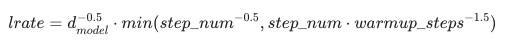

In [36]:
# 학습률 스케줄링 클래스 정의
# Transformer 모델에서 학습률을 조절하기 위해 사용하는 Custom Learning Rate Schedule
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        """
        CustomSchedule 초기화 함수

        Args:
        - d_model: 모델의 임베딩 차원 (d_model).
        - warmup_steps: 워밍업 스텝 수 (default=4000). 학습 초기 단계에서 학습률을 천천히 증가시키기 위한 설정.
        """
        super(CustomSchedule, self).__init__()

        # 모델의 임베딩 차원
        self.d_model = d_model
        # d_model 값을 float32 타입으로 변환 (TensorFlow에서 float32 연산을 위해)
        self.d_model = tf.cast(self.d_model, tf.float32)

        # 워밍업 단계의 스텝 수
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        """
        학습률 계산 함수

        Args:
        - step: 현재 학습 스텝

        Returns:
        - 학습률 (Learning Rate)
        """
        # 1. 현재 스텝(step)의 역제곱근 (step^-0.5)
        arg1 = tf.math.rsqrt(step)

        # 2. 워밍업 단계에서 스텝을 기준으로 한 학습률 증가 값 (step * (warmup_steps^-1.5))
        arg2 = step * (self.warmup_steps**-1.5)

        # 3. d_model의 역제곱근에 최소값(minimum)을 곱하여 학습률 결정
        #    학습률 = d_model^-0.5 * min(step^-0.5, step * warmup_steps^-1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

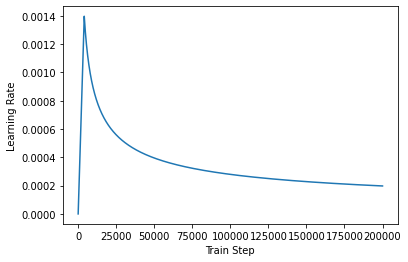

In [37]:
# sample_learning_rate 그래프
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [38]:
# 1. 학습률 스케줄 정의
# CustomSchedule 클래스 인스턴스를 생성하여 학습률 스케줄링 설정
# D_MODEL은 모델의 임베딩 차원 (예: 128, 512 등)
learning_rate = CustomSchedule(D_MODEL)

# 2. Adam 옵티마이저 정의
# Transformer 논문에서 제안된 Adam 옵티마이저 설정
# 학습률 스케줄(learning_rate), beta_1, beta_2, epsilon 값은 논문에 명시된 대로 설정
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,  # 학습률 스케줄 사용
    beta_1=0.9,                   # 1차 모멘트 추정(평균)에 대한 가중치
    beta_2=0.98,                  # 2차 모멘트 추정(분산)에 대한 가중치
    epsilon=1e-9                  # 숫자 안정성 확보를 위한 작은 값
)

# 3. 정확도(Accuracy) 정의
def accuracy(y_true, y_pred):
    """
    정확도를 계산하는 함수.
    Args:
    - y_true: 실제 정답 데이터 (정수형 인덱스).
    - y_pred: 모델이 예측한 확률 분포 (로짓 또는 소프트맥스 결과).

    Returns:
    - 정확도 (배치 내에서 올바르게 예측된 비율).
    """
    # y_true의 shape를 (batch_size, target_seq_len - 1)로 조정
    # MAX_LENGTH는 시퀀스의 최대 길이
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    # sparse_categorical_accuracy는 정수 레이블(y_true)과 예측 확률(y_pred)을 비교하여 정확도를 계산
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# 4. 모델 컴파일
# 옵티마이저, 손실 함수, 정확도를 설정하여 모델을 컴파일
model.compile(
    optimizer=optimizer,      # 학습률 스케줄을 포함한 Adam 옵티마이저
    loss=loss_function,       # 커스텀 손실 함수 (패딩 마스크 포함)
    metrics=[accuracy]        # 정확도 측정 함수
)

### 5. 훈련하기

In [39]:
EPOCHS = 30
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
185/185 [==============================] - 16s 54ms/step - loss: 1.4516 - accuracy: 0.0256
Epoch 2/30
185/185 [==============================] - 10s 54ms/step - loss: 1.1750 - accuracy: 0.0494
Epoch 3/30
185/185 [==============================] - 10s 54ms/step - loss: 1.0039 - accuracy: 0.0506
Epoch 4/30
185/185 [==============================] - 10s 54ms/step - loss: 0.9294 - accuracy: 0.0542
Epoch 5/30
185/185 [==============================] - 10s 54ms/step - loss: 0.8717 - accuracy: 0.0575
Epoch 6/30
185/185 [==============================] - 10s 55ms/step - loss: 0.8124 - accuracy: 0.0614
Epoch 7/30
185/185 [==============================] - 10s 55ms/step - loss: 0.7472 - accuracy: 0.0673
Epoch 8/30
185/185 [==============================] - 10s 55ms/step - loss: 0.6748 - accuracy: 0.0752
Epoch 9/30
185/185 [==============================] - 10s 55ms/step - loss: 0.5967 - accuracy: 0.0837
Epoch 10/30
185/185 [==============================] - 10s 54ms/step - loss: 0.515

### Step 5. 모델 평가하기
---
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

예측(inference) 단계는 기본적으로 다음과 같은 과정을 거칩니다.

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.  

위의 과정을 모두 담은 decoder_inference() 함수를 만듭니다.

In [40]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :] # (batch_size, seq_len, vocab_size) 마지막 타임스텝의 출력만 선택

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가
    # 이 output_sequence는 다시 디코더의 입력이 됨
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 만듭니다.

In [41]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [42]:
sentence_generation('너의 취미는 뭐야?')

입력 : 너의 취미는 뭐야?
출력 : 많은 용기가 필요했을 거예요.


'많은 용기가 필요했을 거예요.'

In [43]:
sentence_generation("내일 비가 올 거 같아?")

입력 : 내일 비가 올 거 같아?
출력 : 허례허식이에요.


'허례허식이에요.'

In [44]:
sentence_generation("오늘의 점심 메뉴를 추천해줘")

입력 : 오늘의 점심 메뉴를 추천해줘
출력 : 색다른걸 드셔보세요.


'색다른걸 드셔보세요.'

In [45]:
sentence_generation("너의 이름은 뭐니?")

입력 : 너의 이름은 뭐니?
출력 : 저는 생각보다 많은 시간이 지났네요.


'저는 생각보다 많은 시간이 지났네요.'

In [46]:
sentence_generation("네가 가장 잘 하는 것은 뭐니?")

입력 : 네가 가장 잘 하는 것은 뭐니?
출력 : 가장 확실한 시간은 오늘이에요. 어제와 내일을 놓고 고민하느라 시간을 낭비하지 마세요.


'가장 확실한 시간은 오늘이에요. 어제와 내일을 놓고 고민하느라 시간을 낭비하지 마세요.'

In [48]:
sentence_generation("너는 누구니?")

입력 : 너는 누구니?
출력 : 저는 마음을 이어주는 위로봇입니다.


'저는 마음을 이어주는 위로봇입니다.'

### 회고
1. 트랜스포머에 대해 디테일 하게 직접 따라서 구현 해보니 이론적으로 공부 했던 내용이 조금씩 와 닿는다.
2. 인코더와 디코더에 각각의 input, output shape 이 아직도 조금 헷갈린다.
3. teacher forcing 부분에 대해 조금더 이해가 필요 할 거 같다.
4. 튜토리얼 나와 있는 모델 구현은 이해가 되는데 데이터 전처리 과정은 역시나 어렵다.
5. 좀 더 나은 전처리 방법이 있을 거 같은데 피어 리뷰 진행 후에 조금 더 업데이트 해보고 싶다.
6. 자연어 처리 타스크는 모델을 평가하는 부분에서도 이해가 많이 필요 할 거 같다.

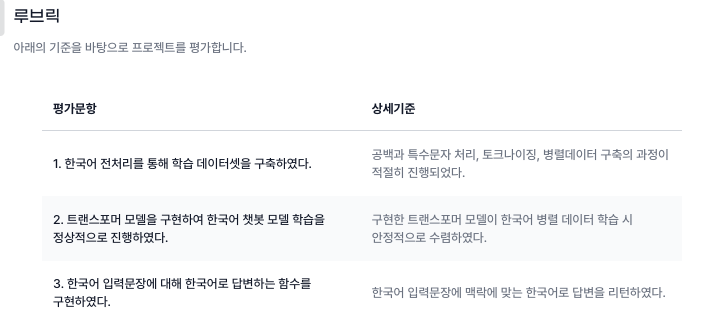